In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats 
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [213]:
df_train = pd.read_csv('all/train.csv')

## Cleaning Up Data

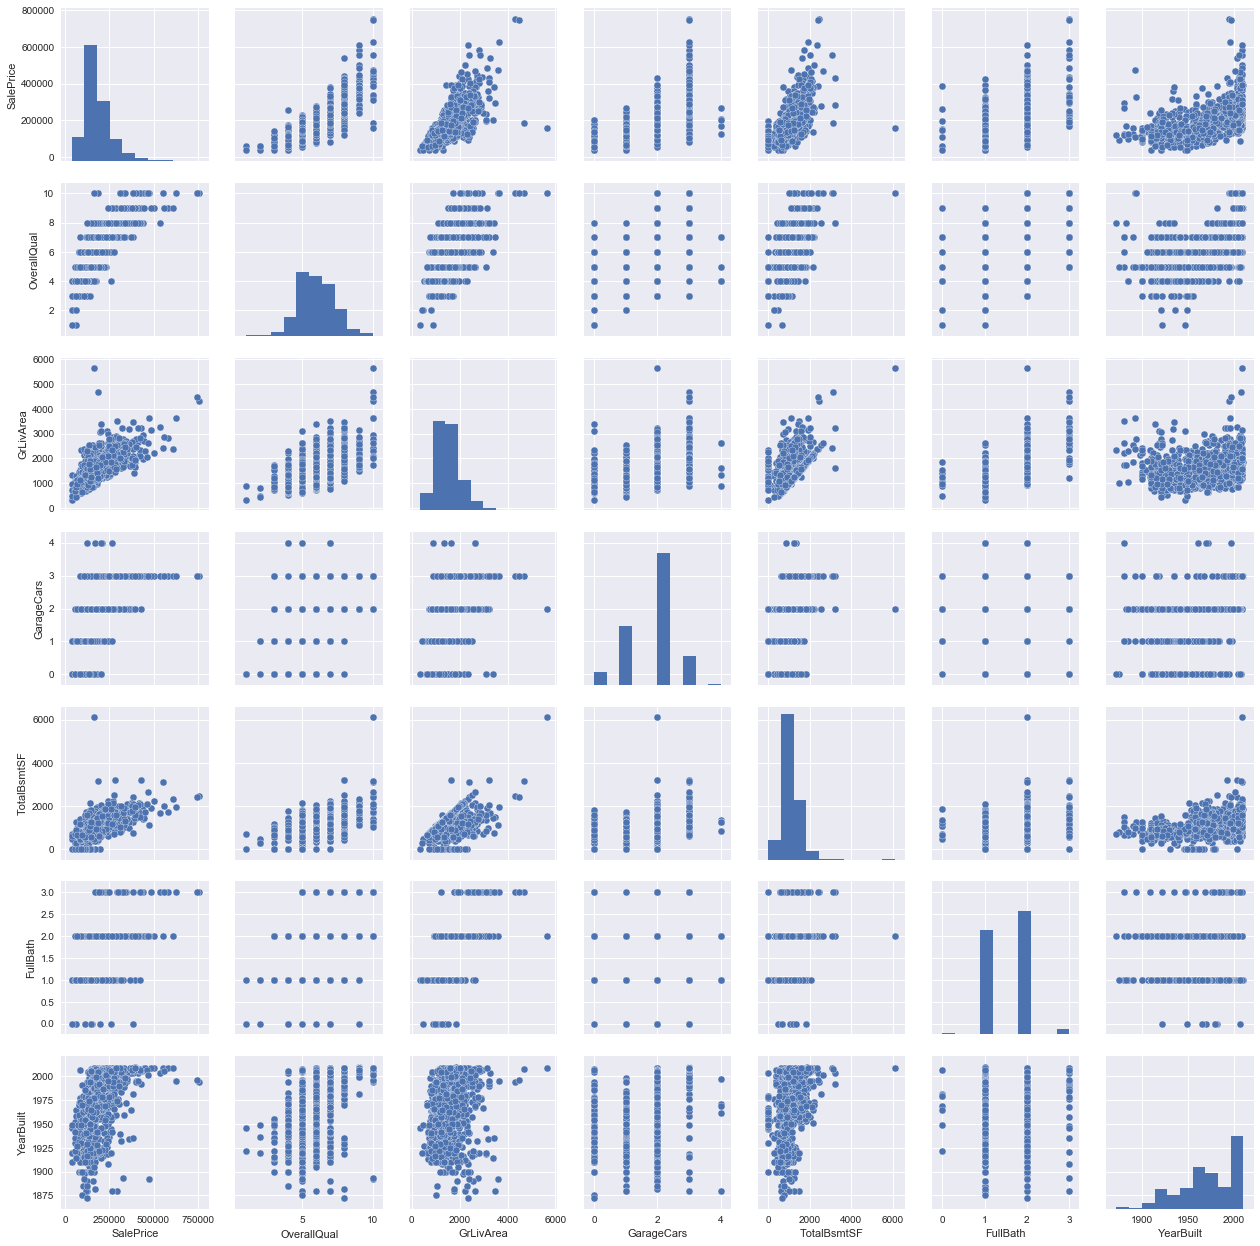

In [214]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',  'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

In [215]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [216]:
# get rid of all columns where data is missing
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

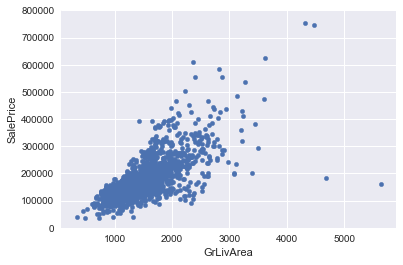

In [217]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x = 'GrLivArea', y = 'SalePrice', ylim = (0,800000))

In [218]:
# get rid of GrLivArea outliers
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

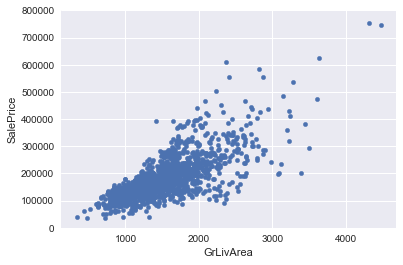

In [219]:
# ensure that the outliers have been removed!

data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x = 'GrLivArea', y = 'SalePrice', ylim = (0,800000))

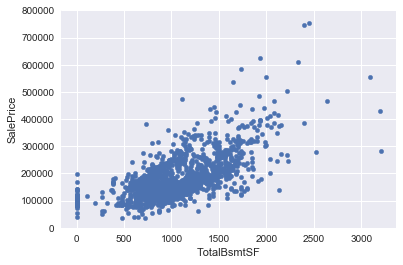

In [220]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

No outlier removal seems necessary in the case of the the TotalBsmtSF data. While there are some extreme values, they seem to generally fit the trend.

## Normalizing the Data

### Sale Price

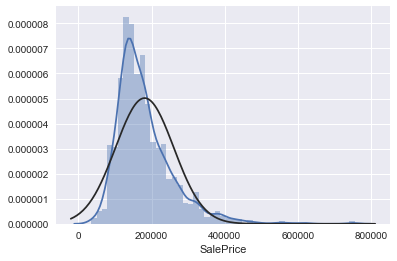

In [221]:
sns.distplot(df_train['SalePrice'], fit = norm)

In [222]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

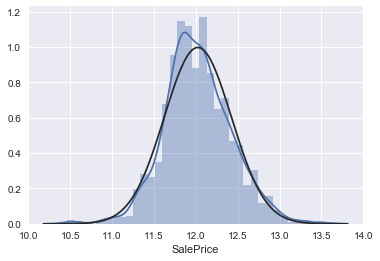

In [223]:
sns.distplot(df_train['SalePrice'], fit = norm)

### Ground Living Area 

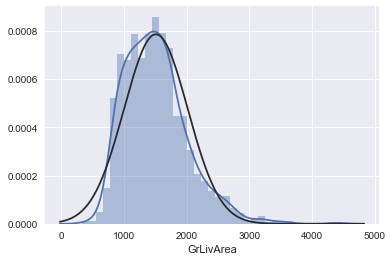

In [224]:
sns.distplot(df_train['GrLivArea'], fit = norm)

In [225]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

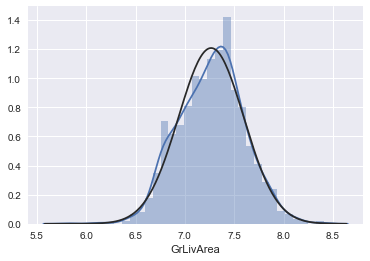

In [226]:
sns.distplot(df_train['GrLivArea'], fit = norm)

### Total Basement Square Footage 

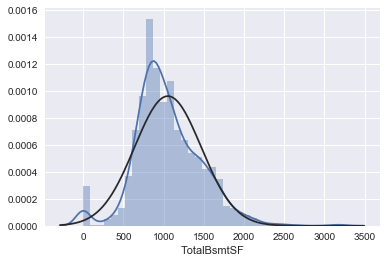

In [227]:
sns.distplot(df_train['TotalBsmtSF'], fit = norm)

In [228]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index = df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [229]:
df_train.loc[df_train['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

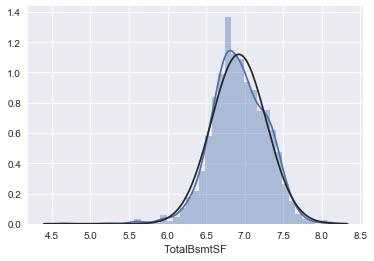

In [230]:
sns.distplot(df_train[df_train['TotalBsmtSF'] >0]['TotalBsmtSF'], fit = norm)

## Training the Model

In [231]:
# set up features to be trained on
cols.remove('SalePrice')
print(cols) 

reg = linear_model.LinearRegression()
reg.fit(df_train[cols], df_train['SalePrice'])

rf = RandomForestRegressor(n_estimators = 500)
rf.fit(df_train[cols], df_train['SalePrice'])

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Testing the Model

In [232]:
df_test = pd.read_csv('all/test.csv')
df_test = df_test.fillna(df_test.mean())

### Normalizing the Test Data

In [233]:
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index = df_test.index)
df_test['HasBsmt'] = 0
df_test.loc[df_test['TotalBsmtSF'] > 0, 'HasBsmt'] = 1

In [234]:
df_test.loc[df_test['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(df_test['TotalBsmtSF'])

In [235]:
log_reg_preds = reg.predict(df_test[cols])
reg_preds = np.exp(log_price_preds)

log_rf_preds = rf.predict(df_test[cols])
rf_preds = np.exp(log_rf_preds)

price_preds = (0.25 * reg_preds) + (0.75 * rf_preds)

In [236]:
solution = pd.DataFrame({"id":df_test['Id'], "SalePrice": price_preds})
solution.to_csv("basic_sol.csv", index = False)